In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import utils

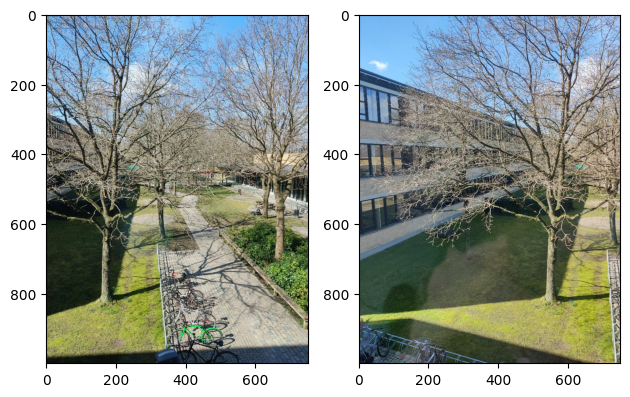

In [2]:
im1 = cv2.imread("im1.jpg")[:,:,::-1]
im2 = cv2.imread("im2.jpg")[:,:,::-1]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(im1)
axs[1].imshow(im2)
plt.tight_layout()
plt.show()

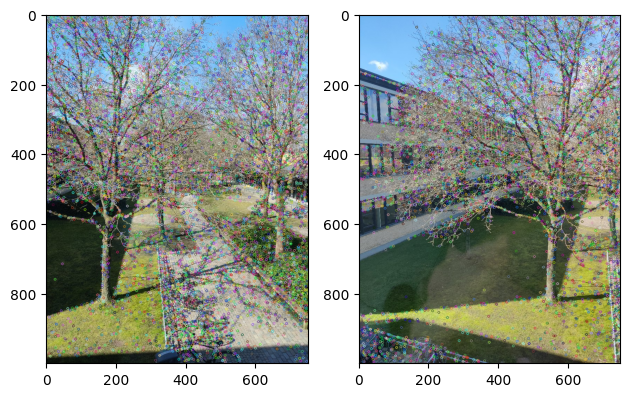

In [3]:
sift = cv2.SIFT.create()
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)
im1_kps = cv2.drawKeypoints(im1, kp1, None)
im2_kps = cv2.drawKeypoints(im2, kp2, None)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(im1_kps)
axs[1].imshow(im2_kps)
plt.tight_layout()
plt.show()

In [4]:
bf = cv2.BFMatcher_create(crossCheck=True)
matches = bf.match(des1, des2)
sorted_matches = sorted(matches, key = lambda x:x.distance)

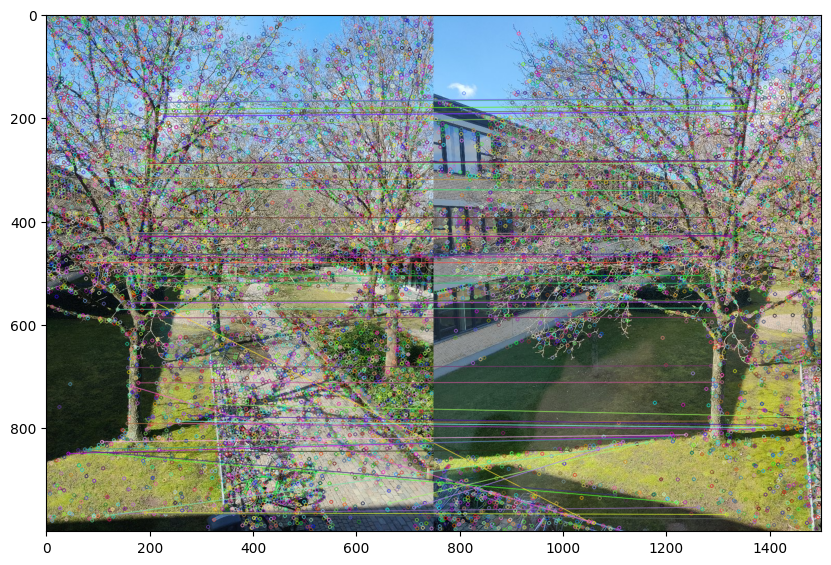

In [5]:
mimg = cv2.drawMatches(im1, kp1, im2, kp2, sorted_matches[:50], None)
plt.figure(figsize = (10,10))
plt.imshow(mimg)

In [6]:
def get_inliers(matches, kps1, kps2, H, sigma):
    kps1 = [kps1[match.queryIdx].pt for match in matches]
    kps2 = [kps2[match.trainIdx].pt for match in matches]
    inliers = []
    min = math.inf
    for i in range(len(kps1)):
        kp1 = np.expand_dims(np.asarray(kps1[i]), axis=0).T
        kp2 = np.expand_dims(np.asarray(kps2[i]), axis=0).T
        d1 = np.square(kp1 - utils.Pi(H @ utils.PiInv(kp2))).sum()
        d2 = np.square(kp2 - utils.Pi(np.linalg.inv(H) @ utils.PiInv(kp1))).sum()
        err = d1 + d2
        if err < min: min = err
        if err < 5.99*sigma**2: inliers.append(i)
    return inliers

In [7]:
def ransac(matches, kp1, kp2, N, sigma):
    best_inl = []
    for i in range(N):
        sample_kp1, sample_kp2 = utils.sample(matches, kp1, kp2, size=4)
        H = utils.hest(sample_kp1, sample_kp2)
        inliers = get_inliers(matches, kp1, kp2, H, sigma)
        if len(inliers) > len(best_inl):
            best_inl = inliers
    print(f'Num of inliers: {len(best_inl)}')
    return best_inl

In [8]:
best_inl = ransac(matches, kp1, kp2, 200, 3)

Num of inliers: 443


In [9]:
kps1 = [kp1[matches[i].queryIdx].pt for i in best_inl]
kps2 = [kp2[matches[i].trainIdx].pt for i in best_inl]
H_est = utils.hest(np.asarray(kps1).T, np.asarray(kps2).T)
print(H_est)

[[-2.31100899e-03 -4.28906861e-05  9.41582073e-01]
 [-5.85539696e-04 -2.11595382e-03  3.36765698e-01]
 [-1.24347485e-06 -3.82863293e-08 -1.37928128e-03]]


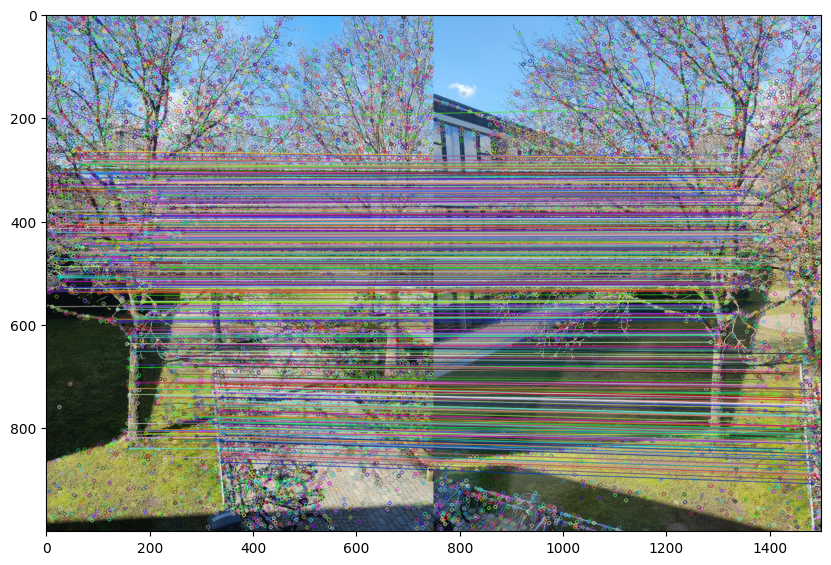

In [10]:
plt.figure(figsize = (10,10))
plt.imshow(cv2.drawMatches(im1, kp1, im2, kp2, np.array(matches)[best_inl], None))

In [11]:
def estHomographyRANSAC(kp1, des1, kp2, des2):
    bf = cv2.BFMatcher_create(crossCheck=True)
    matches = bf.match(des1, des2)
    best_inl = ransac(matches, kp1, kp2, 200, 3)
    kps1 = [kp1[matches[i].queryIdx].pt for i in best_inl]
    kps2 = [kp2[matches[i].trainIdx].pt for i in best_inl]
    return utils.hest(np.asarray(kps1).T, np.asarray(kps2).T)

In [12]:
H = estHomographyRANSAC(kp1, des1, kp2, des2)
print(H)

Num of inliers: 767
[[-2.31303233e-03 -3.56548640e-05  9.39831363e-01]
 [-6.16420789e-04 -2.08513881e-03  3.41621248e-01]
 [-1.31409309e-06  1.30193741e-08 -1.36139348e-03]]


In [13]:
def warpImage(im, H, xRange, yRange):
    T = np.eye(3)
    T[:2, 2] = [-xRange[0], -yRange[0]]
    H = T@H
    outSize = (xRange[1]-xRange[0], yRange[1]-yRange[0])
    mask = np.ones(im.shape[:2], dtype=np.uint8)*255
    imWarp = cv2.warpPerspective(im, H, outSize)
    maskWarp = cv2.warpPerspective(mask, H, outSize)
    return imWarp, maskWarp

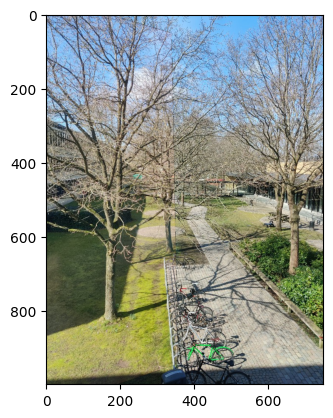

In [14]:
xRange = [0, im1.shape[1]]
yRange = [0, im1.shape[0]]
imWarp2, maskWarp2 = warpImage(im2, H, xRange, yRange)
H_dummy = np.eye(3)
imWarp1, maskWarp1 = warpImage(im1, H_dummy, xRange, yRange)
mask = np.stack((maskWarp2,) * 3, axis=-1)
blended_image = np.where(mask, imWarp2, im1)
plt.imshow(blended_image)